Import Library

In [1]:
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

Data Loading

In [2]:
data = pd.read_csv(r"D:\Kaggle_competition\Time Series Forecasting\PJMW_hourly.csv\PJMW_hourly.csv")

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143206 entries, 6574 to 138094
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  143206 non-null  datetime64[ns]
 1   PJMW_MW   143206 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 MB


In [3]:
data.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


In [4]:
data

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


In [5]:
data.isnull().sum()

Datetime    0
PJMW_MW     0
dtype: int64

In [6]:
data.duplicated().sum()

0

Data Visualization

In [9]:
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [14]:
data

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


In [15]:
data = data.sort_values(by='Datetime')

In [16]:
data

,Datetime,PJMW_MW
6574,2002-04-01 01:00:00,4374.0
6575,2002-04-01 02:00:00,4306.0
6576,2002-04-01 03:00:00,4322.0
6577,2002-04-01 04:00:00,4359.0
6578,2002-04-01 05:00:00,4436.0
...,...,...
138090,2018-08-02 20:00:00,6545.0
138091,2018-08-02 21:00:00,6496.0
138092,2018-08-02 22:00:00,6325.0
138093,2018-08-02 23:00:00,5892.0


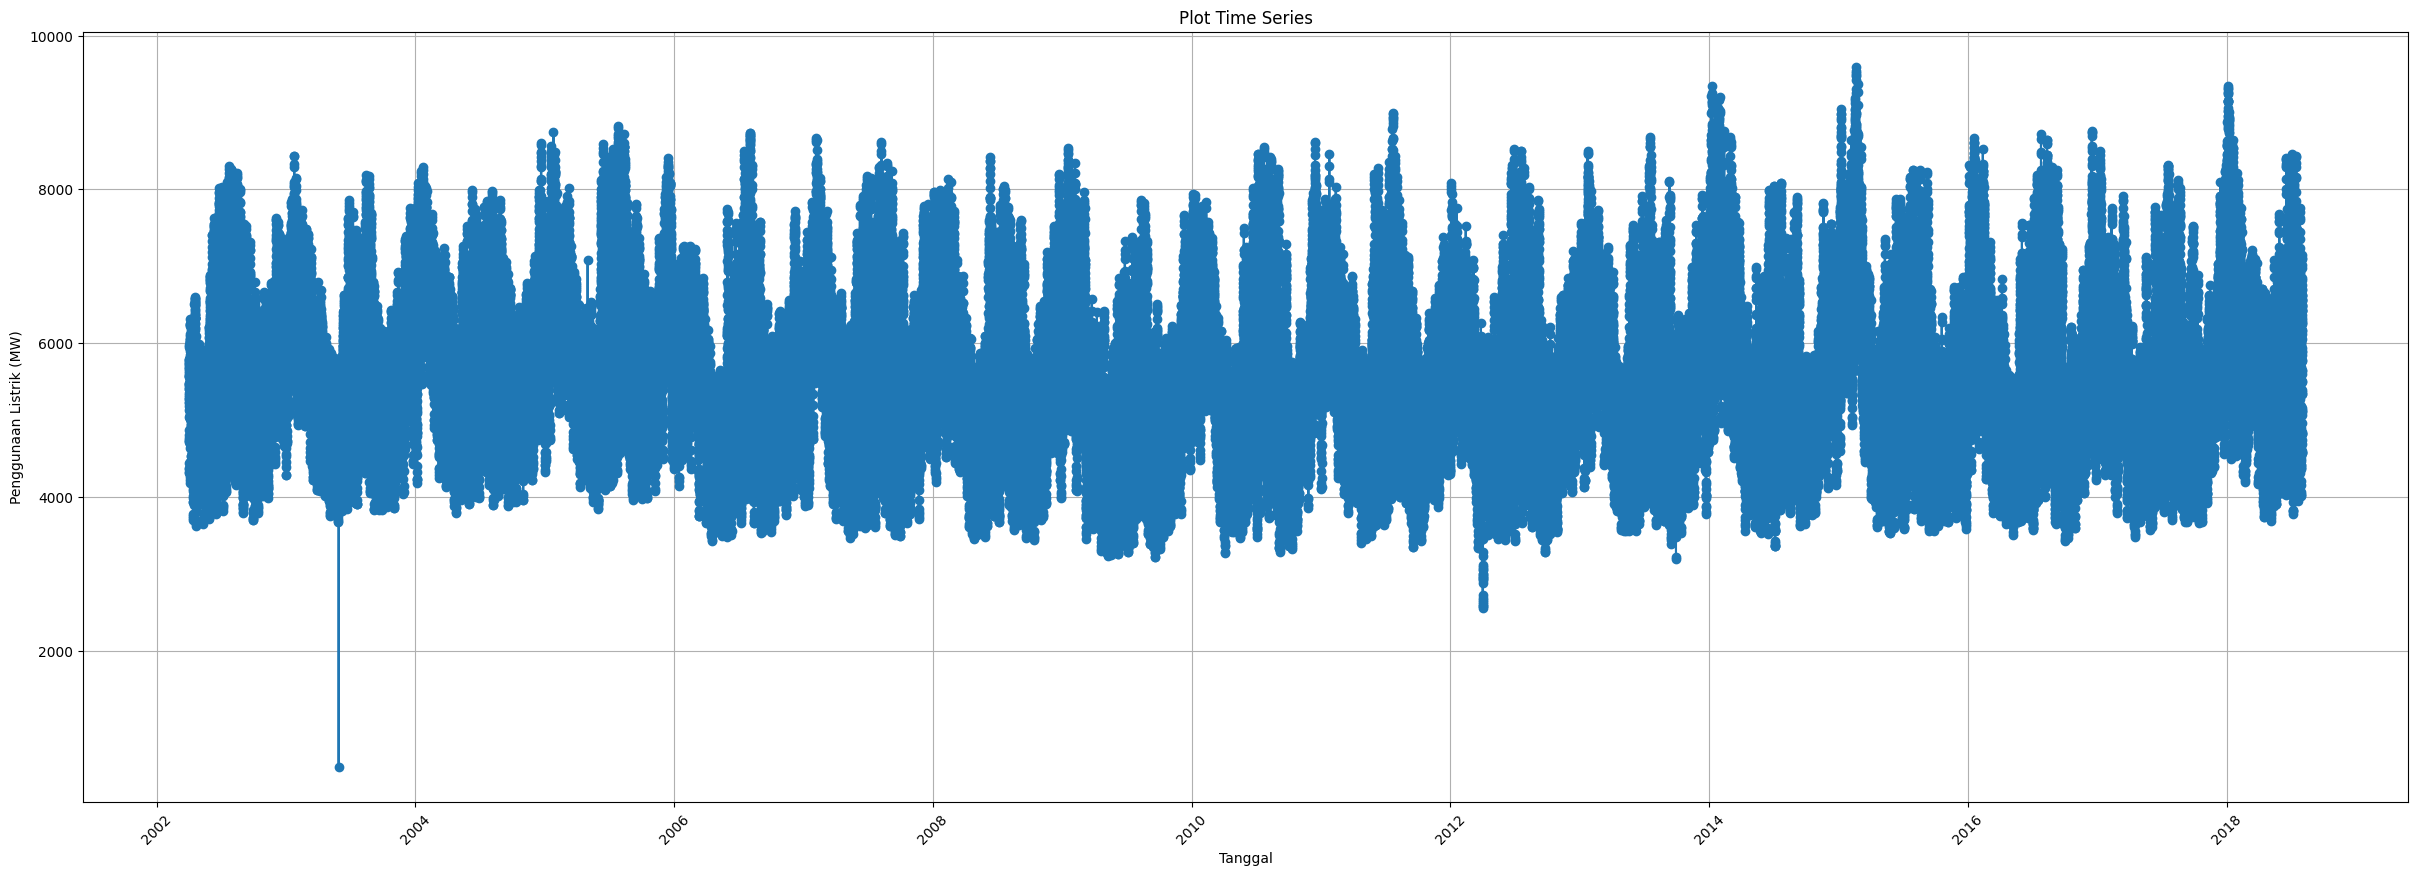

In [17]:
plt.figure(figsize=(30, 10))
plt.plot(data['Datetime'], data['PJMW_MW'], marker='o', linestyle='-')
plt.xlabel('Tanggal')
plt.ylabel('Penggunaan Listrik (MW)')
plt.title('Plot Time Series')
plt.grid()
plt.xticks(rotation=45)
plt.show()

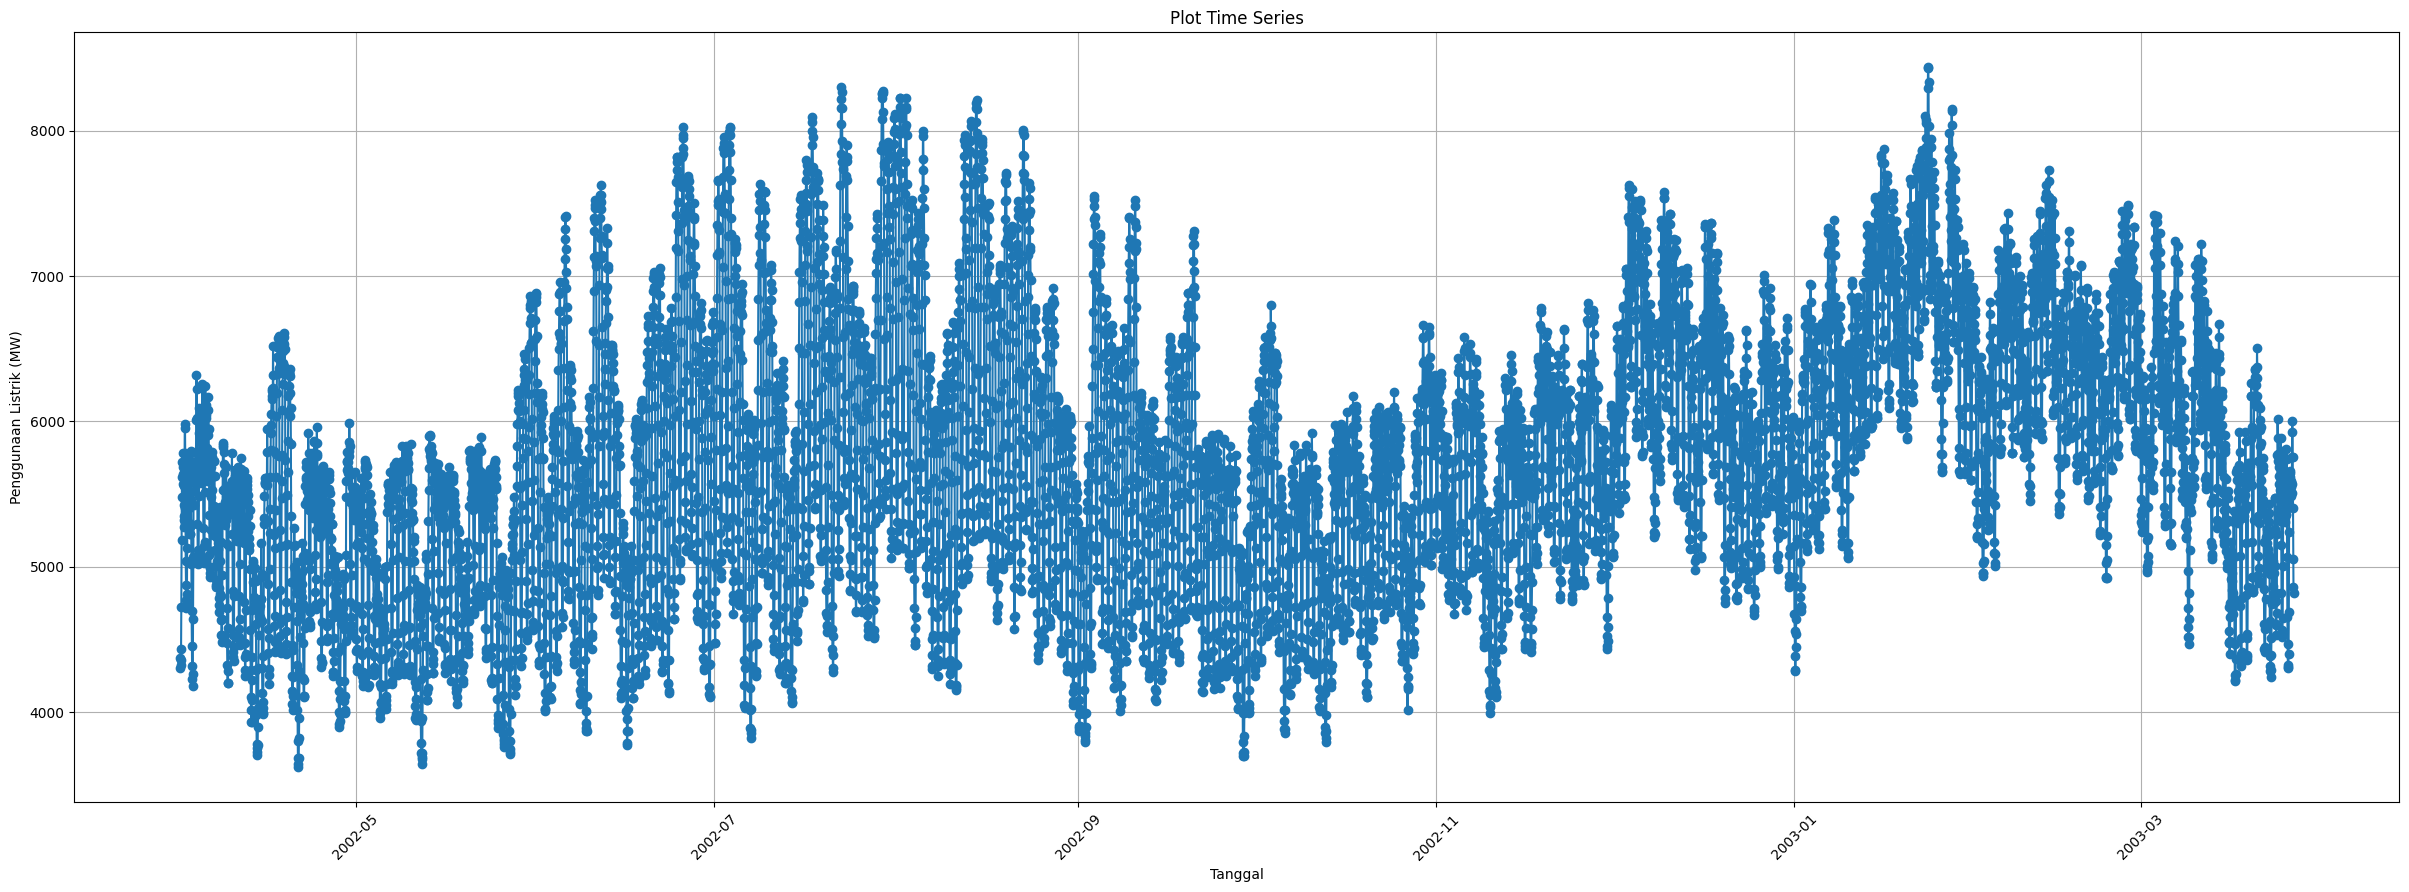

In [18]:
plt.figure(figsize=(30, 10))
plt.plot(data['Datetime'][:8640], data['PJMW_MW'][:8640], marker='o', linestyle='-')
plt.xlabel('Tanggal')
plt.ylabel('Penggunaan Listrik (MW)')
plt.title('Plot Time Series')
plt.grid()
plt.xticks(rotation=45)
plt.show()

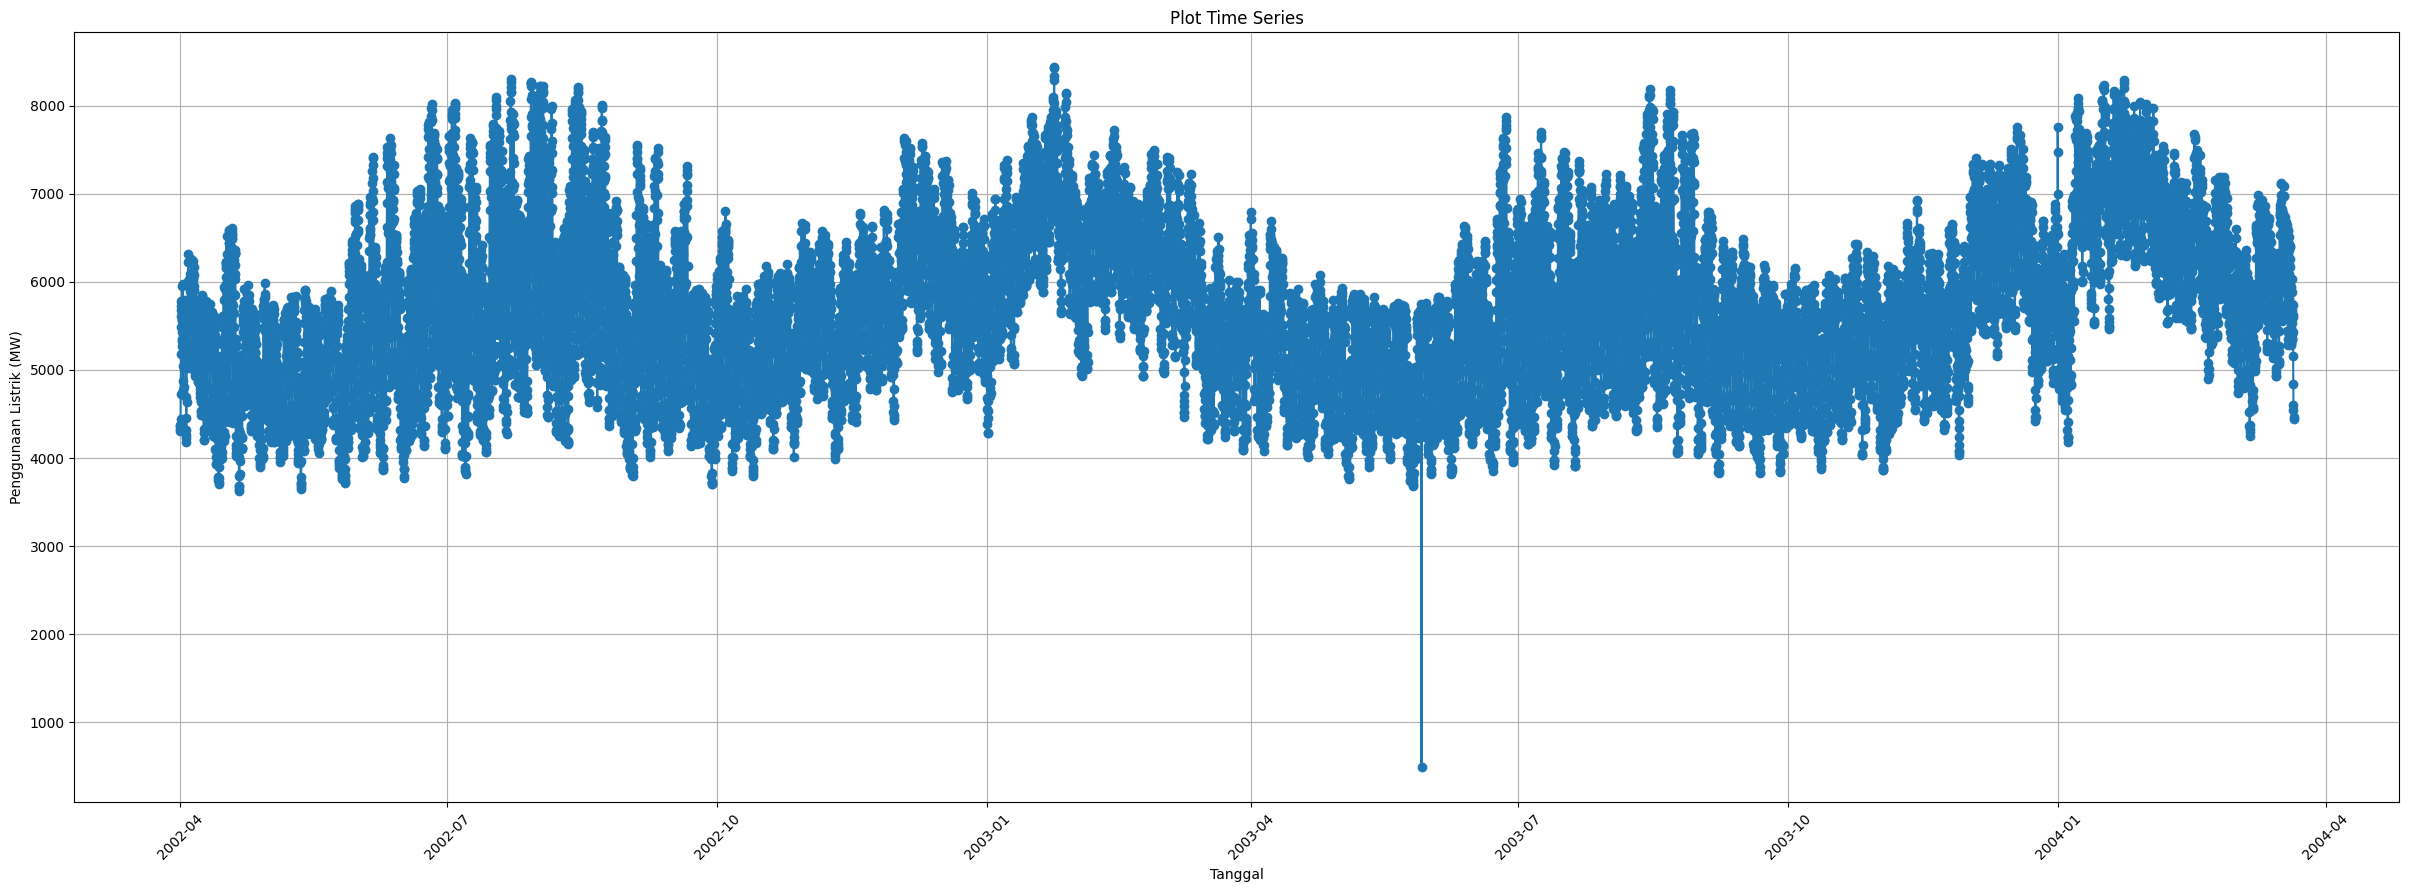

In [19]:
plt.figure(figsize=(30, 10))
plt.plot(data['Datetime'][:17280], data['PJMW_MW'][:17280], marker='o', linestyle='-')
plt.xlabel('Tanggal')
plt.ylabel('Penggunaan Listrik (MW)')
plt.title('Plot Time Series')
plt.grid()
plt.xticks(rotation=45)
plt.show()

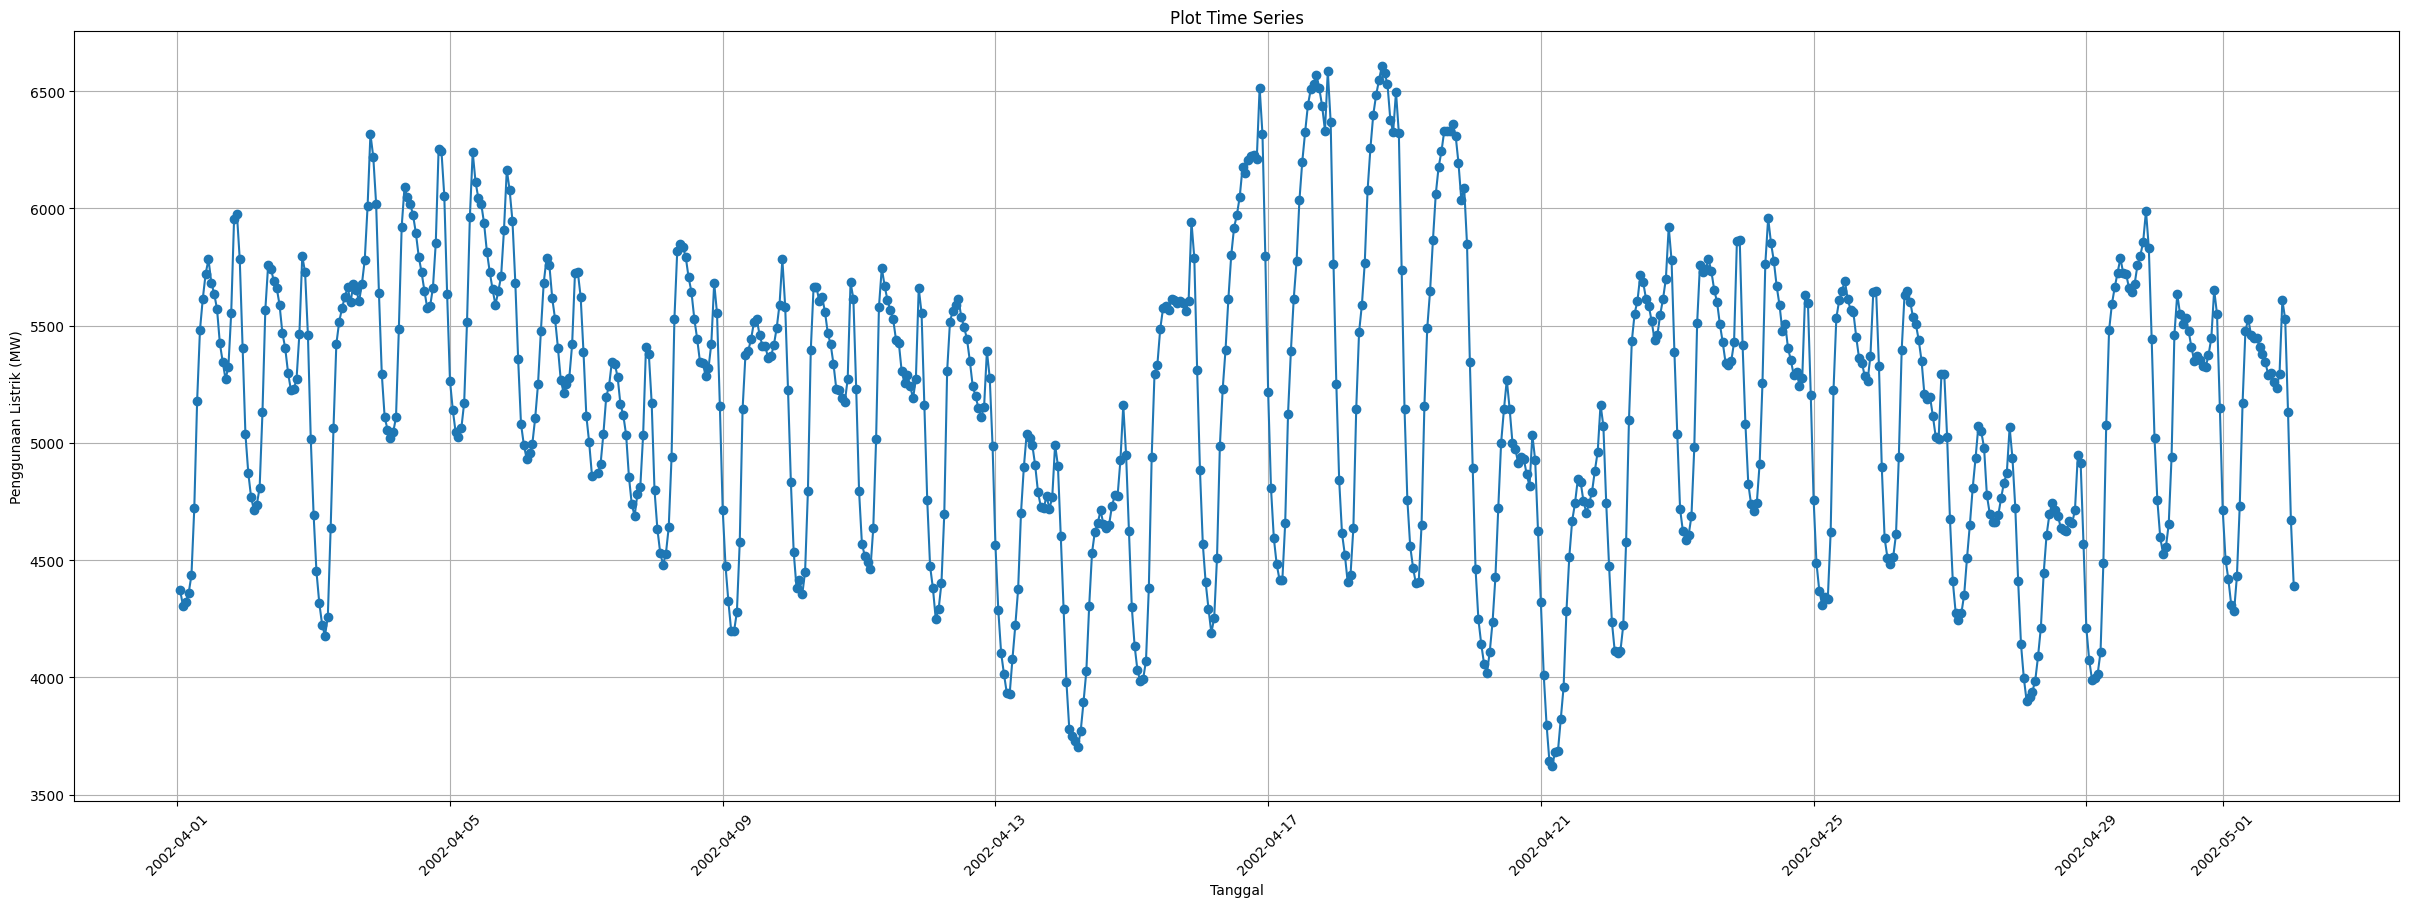

In [20]:
plt.figure(figsize=(30, 10))
plt.plot(data['Datetime'][:744], data['PJMW_MW'][:744], marker='o', linestyle='-')
plt.xlabel('Tanggal')
plt.ylabel('Penggunaan Listrik (MW)')
plt.title('Plot Time Series')
plt.grid()
plt.xticks(rotation=45)
plt.show()

Data Preprocessing

Missing Value

In [21]:
full_range = pd.date_range(start=data['Datetime'].min(), end=data['Datetime'].max(), freq='h')

missing_timestamps = full_range.difference(data['Datetime'])

missing_timestamps

DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
data = pd.DataFrame({'Datetime': full_range}).merge(data, on='Datetime', how='left')

data

,Datetime,PJMW_MW
0,2002-04-01 01:00:00,4374.0
1,2002-04-01 02:00:00,4306.0
2,2002-04-01 03:00:00,4322.0
3,2002-04-01 04:00:00,4359.0
4,2002-04-01 05:00:00,4436.0
...,...,...
143231,2018-08-02 20:00:00,6545.0
143232,2018-08-02 21:00:00,6496.0
143233,2018-08-02 22:00:00,6325.0
143234,2018-08-02 23:00:00,5892.0


In [17]:
data.isnull().sum()

Datetime     0
PJMW_MW     30
dtype: int64

In [18]:
data['PJMW_MW'] = data['PJMW_MW'].interpolate()

In [19]:
data.isnull().sum()

Datetime    0
PJMW_MW     0
dtype: int64

Feature Extraction

In [ ]:
data['year'] = data['Datetime'].dt.year          
data['month'] = data['Datetime'].dt.month      
data['day'] = data['Datetime'].dt.day       
data['day_of_week'] = data['Datetime'].dt.dayofweek   
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)  
data['hour'] = data['Datetime'].dt.hour         

In [25]:
data

,Datetime,PJMW_MW,year,month,day,day_of_week,is_weekend,hour
0,2002-04-01 01:00:00,4374.0,2002,4,1,0,0,1
1,2002-04-01 02:00:00,4306.0,2002,4,1,0,0,2
2,2002-04-01 03:00:00,4322.0,2002,4,1,0,0,3
3,2002-04-01 04:00:00,4359.0,2002,4,1,0,0,4
4,2002-04-01 05:00:00,4436.0,2002,4,1,0,0,5
...,...,...,...,...,...,...,...,...
143231,2018-08-02 20:00:00,6545.0,2018,8,2,3,0,20
143232,2018-08-02 21:00:00,6496.0,2018,8,2,3,0,21
143233,2018-08-02 22:00:00,6325.0,2018,8,2,3,0,22
143234,2018-08-02 23:00:00,5892.0,2018,8,2,3,0,23


Scaling

In [ ]:
features = ['year', 'month', 'day', 'day_of_week', 'is_weekend', 'hour']
target = 'PJMW_MW'

In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

data[features] = scaler_X.fit_transform(data[features])
data[target] = scaler_y.fit_transform(data[[target]])

Data Reshaping for Sequence Modeling

In [ ]:
def create_sequences(data, target_col, window_size, output_size):
    X, x_lstm, y = [], [], []
    for i in range(len(data) - window_size - output_size + 1):
        X.append(data[features].iloc[i:i+window_size].values)
        x_lstm.append(data[target].iloc[i:i+window_size].values)
        y.append(data[target_col].iloc[i+window_size:i+window_size+output_size].values)
    return np.array(X), np.array(x_lstm), np.array(y)

window_size = 336
output_size = 72

X_seq, x_lstm, y_multi = create_sequences(data, target, window_size, output_size)

In [ ]:
X_seq = X_seq.reshape((X_seq.shape[0], window_size, len(features)))
x_lstm = x_lstm.reshape((x_lstm.shape[0], window_size, 1))

print(f"Shape X_seq: {X_seq.shape}, x_lstm : {x_lstm.shape}, y_multi: {y_multi.shape}")

Shape X_seq: (142829, 336, 6), x_lstm : (142829, 336, 1), y_multi: (142829, 72)


Splitting

In [ ]:
x_lstm_train = x_lstm[:-72]
x_lstm_val = x_lstm[-72:]
y_multi_train = y_multi[:-72]
y_multi_val = y_multi[-72:]

Modelling

LSTM Model

In [ ]:
earlystop_cb = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss', mode='min')

lstm_model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(32, activation='relu'),
    Dense(output_size)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

lstm_model.fit(
    x_lstm_train, y_multi_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[earlystop_cb]
)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
4016/4016 ━━━━━━━━━━━━━━━━━━━━ 854s 211ms/step - loss: 0.0184 - mse: 0.0184 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 2/15
4016/4016 ━━━━━━━━━━━━━━━━━━━━ 852s 212ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 3/15
4016/4016 ━━━━━━━━━━━━━━━━━━━━ 842s 210ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 4/15
4016/4016 ━━━━━━━━━━━━━━━━━━━━ 882s 220ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 5/15
4016/4016 ━━━━━━━━━━━━━━━━━━━━ 827s 206ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 6/15
4016/4016 ━━━━━━━━━━━━━━━━━━━━ 1053s 262ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 7/15
4016/4016 ━━━━━━━━━━━━━━━━━━━━ 969s 241ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 8/15
4016/4016 ━━━━━━━━━━━━━━━━━━━━ 891s 222ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 9

In [ ]:
X_features = lstm_model.predict(x_lstm)

4464/4464 ━━━━━━━━━━━━━━━━━━━━ 311s 69ms/step


In [ ]:
X_features.shape

(142829, 72)

Model for Structured Data

Data Flattening

In [ ]:
X_seq_reshaped = X_seq.reshape(X_seq.shape[0], -1)

seq_columns = [f'seq_{i}' for i in range(X_seq_reshaped.shape[1])]

df_seq = pd.DataFrame(X_seq_reshaped, columns=seq_columns)

In [ ]:
feature_columns = [f'feature_{i}' for i in range(X_features.shape[1])]

df_feat = pd.DataFrame(X_features, columns=feature_columns)

In [ ]:
feature_columns = [f'output_{i}' for i in range(y_multi.shape[1])]

df_output = pd.DataFrame(y_multi, columns=feature_columns)

Merge the Data to be an Input

In [ ]:
df_combined = pd.concat([df_feat, df_seq], axis=1)  # Shape: (142829, 2088)

In [ ]:
df_combined

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,seq_2006,seq_2007,seq_2008,seq_2009,seq_2010,seq_2011,seq_2012,seq_2013,seq_2014,seq_2015
0,0.470155,0.450487,0.436234,0.431106,0.436855,0.451616,0.471342,0.491250,0.508217,0.521075,...,0.433333,1.0,1.0,1.000000,0.0,0.272727,0.466667,0.000000,0.0,0.000000
1,0.447029,0.435248,0.430849,0.436384,0.451940,0.473068,0.493369,0.507456,0.514575,0.517564,...,0.466667,0.0,0.0,0.000000,0.0,0.272727,0.466667,0.000000,0.0,0.043478
2,0.437005,0.439347,0.450383,0.468078,0.489675,0.510838,0.526897,0.534600,0.534623,0.530561,...,0.466667,0.0,0.0,0.043478,0.0,0.272727,0.466667,0.000000,0.0,0.086957
3,0.439384,0.454271,0.477333,0.502377,0.524485,0.540887,0.550231,0.552096,0.547904,0.540327,...,0.466667,0.0,0.0,0.086957,0.0,0.272727,0.466667,0.000000,0.0,0.130435
4,0.449434,0.472545,0.501428,0.527376,0.544727,0.553366,0.555689,0.553534,0.548324,0.541041,...,0.466667,0.0,0.0,0.130435,0.0,0.272727,0.466667,0.000000,0.0,0.173913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142824,0.620037,0.596453,0.568536,0.542216,0.520271,0.503067,0.492055,0.489253,0.495535,0.509142,...,0.966667,0.0,0.0,0.826087,1.0,0.545455,0.966667,0.000000,0.0,0.869565
142825,0.610810,0.581089,0.549590,0.523812,0.506187,0.495411,0.491360,0.495097,0.506871,0.523964,...,0.966667,0.0,0.0,0.869565,1.0,0.545455,0.966667,0.000000,0.0,0.913043
142826,0.585828,0.551300,0.519573,0.498250,0.489107,0.489363,0.496840,0.510156,0.527680,0.545926,...,0.966667,0.0,0.0,0.913043,1.0,0.545455,0.966667,0.000000,0.0,0.956522
142827,0.561246,0.527746,0.500388,0.485313,0.484220,0.494876,0.513446,0.534846,0.555266,0.572078,...,0.966667,0.0,0.0,0.956522,1.0,0.545455,0.966667,0.000000,0.0,1.000000


In [ ]:
# df_combined.to_csv('input__untuk_xgboost_multi_output.csv', index=False)

In [ ]:
# df_output.to_csv('output__untuk_xgboost_multi_output.csv', index=False)

Splitting

In [ ]:
df_combined_train = df_combined[:-72]
df_combined_val = df_combined[-72:]
df_output_train = df_output[:-72]
df_output_val = df_output[-72:]

XGBoost Model

In [ ]:
xgb_regressor = XGBRegressor()
multi_xgb = MultiOutputRegressor(xgb_regressor)

multi_xgb.fit(df_combined_train, df_output_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [ ]:
# with open('multi_xgb_model.pkl', 'wb') as f:
#     pickle.dump(multi_xgb, f)

Prediction and Model Evaluation

In [ ]:
input = pd.read_csv('input__untuk_xgboost_multi_output.csv')
output = pd.read_csv('output__untuk_xgboost_multi_output.csv')

with open('multi_xgb_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [31]:
y_pred = model.predict(input[-72:])
y_pred_original = scaler_y.inverse_transform(y_pred)  # Kembalikan ke skala asli

print("Prediksi multi-output (72 jam ke depan):", y_pred_original)

Prediksi multi-output (72 jam ke depan): [[4556.4355 4350.0303 4228.2173 ... 5833.4785 5176.4834 5005.981 ]
 [4422.9146 4352.7036 4328.8105 ... 5461.001  4746.6157 4777.807 ]
 [4276.952  4268.9478 4255.1313 ... 5267.103  4629.9067 4568.5127]
 ...
 [5384.2607 5049.927  4749.742  ... 7136.265  6371.222  6780.273 ]
 [5032.027  4841.266  4584.8647 ... 6802.426  6579.6377 6269.0103]
 [4753.2876 4572.5527 4409.887  ... 6714.203  5615.9126 5767.5435]]


In [37]:
y_pred_ori = y_pred_original[-1:]

In [38]:
y_pred_ori

array([[4753.2876, 4572.5527, 4409.887 , 4242.441 , 4504.066 , 4584.2437,
        4975.9326, 5067.5566, 5449.3076, 5893.4883, 6044.702 , 6095.654 ,
        6374.313 , 6449.853 , 6429.4175, 6791.893 , 6623.0166, 6600.6206,
        6745.705 , 6658.0474, 6235.1157, 6304.321 , 5647.1025, 5516.375 ,
        4994.283 , 4903.193 , 4602.7153, 4502.8486, 4795.133 , 4962.1855,
        5118.326 , 5278.973 , 5622.4146, 5817.9272, 6305.942 , 6187.012 ,
        6599.244 , 6998.5166, 6715.503 , 6278.7725, 6990.4204, 7055.7173,
        7303.346 , 6896.632 , 6900.26  , 6815.5405, 6185.0474, 5591.79  ,
        5201.4097, 5081.1904, 4660.165 , 4831.6206, 4638.3047, 4987.997 ,
        5377.097 , 5466.9404, 5899.4595, 5910.439 , 6297.139 , 6781.0454,
        6520.734 , 7018.5176, 7300.042 , 6866.6025, 6550.9473, 7197.632 ,
        7229.7046, 6861.2217, 6795.0083, 6714.203 , 5615.9126, 5767.5435]],
      dtype=float32)

In [41]:
output_last = output[-1:]

In [42]:
output_last

,output_0,output_1,output_2,output_3,output_4,output_5,output_6,output_7,output_8,output_9,...,output_62,output_63,output_64,output_65,output_66,output_67,output_68,output_69,output_70,output_71
142828,0.478753,0.444493,0.439772,0.429011,0.437466,0.458878,0.490612,0.513012,0.538267,0.567256,...,0.659383,0.674207,0.683101,0.688591,0.681454,0.665203,0.659822,0.641045,0.5935,0.549248


In [43]:
output_last_ori = scaler_y.inverse_transform(output_last)

In [44]:
output_last_ori = output_last_ori.astype(float)

In [45]:
output_last_ori

array([[4847., 4535., 4492., 4394., 4471., 4666., 4955., 5159., 5389.,
        5653., 5936., 6264., 6416., 6559., 6621., 6562., 6466., 6480.,
        6426., 6276., 6250., 6123., 5771., 5343., 5061., 4817., 4687.,
        4588., 4565., 4815., 5135., 5509., 5644., 5846., 6165., 6419.,
        6614., 6853., 6980., 7090., 7113., 7147., 7012., 6816., 6571.,
        6362., 5881., 5363., 5100., 4840., 4745., 4572., 4594., 4826.,
        5114., 5333., 5597., 5775., 6050., 6152., 6299., 6425., 6492.,
        6627., 6708., 6758., 6693., 6545., 6496., 6325., 5892., 5489.]])

In [ ]:
mse = mean_squared_error(output_last_ori, y_pred_ori)
mae = mean_absolute_error(output_last_ori, y_pred_ori)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(output_last_ori, y_pred_ori)

print(f"MSE  : {mse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.5f}")

MSE  : 71065.99
MAE  : 206.69
RMSE : 266.58
MAPE : 0.03450
